In [1]:
# Importing standard Qiskit libraries
from qiskit import QuantumCircuit, transpile
from qiskit.tools.jupyter import *
from qiskit.visualization import *
from ibm_quantum_widgets import *

# qiskit-ibmq-provider has been deprecated.
# Please see the Migration Guides in https://ibm.biz/provider_migration_guide for more detail.
from qiskit_ibm_runtime import QiskitRuntimeService, Sampler, Estimator, Session, Options

# Loading your IBM Quantum account(s)
service = QiskitRuntimeService(channel="ibm_quantum")

# Invoke a primitive. For more details see https://qiskit.org/documentation/partners/qiskit_ibm_runtime/tutorials.html
# result = Sampler("ibmq_qasm_simulator").run(circuits).result()

In [2]:
from qiskit import Aer
from collections import defaultdict
from qiskit import QuantumCircuit, transpile,execute, Aer
import networkx as nx
from qiskit.circuit.quantumcircuit import QuantumCircuit
from qiskit.circuit import QuantumCircuit, ParameterVector
import numpy as np
from scipy.optimize import minimize 
from math import pi, acos
#from qiskit.optimization.applications.ising import tsp
from qiskit_optimization.applications import Tsp
#from qiskit.aqua.algorithms import NumPyMinimumEigensolver, QAOA
from qiskit.algorithms.minimum_eigensolvers import QAOA , NumPyMinimumEigensolver
#from qiskit.aqua import aqua_globals, QuantumInstance
from qiskit.utils import QuantumInstance
from qiskit_optimization.algorithms import MinimumEigenOptimizer
#from qiskit.optimization.problems import QuadraticProgram
from qiskit_optimization import QuadraticProgram
from qiskit_optimization.converters import QuadraticProgramToQubo
from qiskit.primitives import Sampler
from qiskit.circuit.library.n_local.qaoa_ansatz import QAOAAnsatz
from qiskit.quantum_info.operators import Operator # Generating a TSP instance of n cities
import itertools
import matplotlib.pyplot as plt
#THE BELOW FUNCTION CALCULATES TSP CLASSICALLY
#from qiskit.opflow import WeightedPauliOperator

In [3]:
#THIS PART CREATES AN INSTANCE OF TSP THEN IT CONVERTS THAT INTO PAULI OPERATOR LIST(IN SHORT THIS WHERE ENCODING PART IS DONE)

v = 3
n = v ** 2
tsp =Tsp.create_random_instance(v, seed=46516)
adj_matrix = nx.to_numpy_array(tsp.graph)
print("distance\n", adj_matrix)

# Create a random TSP Hamiltonian
qp = tsp.to_quadratic_program()
print(qp.prettyprint())

qp2qubo = QuadraticProgramToQubo()
qubo = qp2qubo.convert(qp)
qubitOp, offset = qubo.to_ising()
print(qubitOp, offset)


distance
 [[ 0. 62. 29.]
 [62.  0. 76.]
 [29. 76.  0.]]
Problem name: TSP

Minimize
  62*x_0_0*x_1_1 + 62*x_0_0*x_1_2 + 29*x_0_0*x_2_1 + 29*x_0_0*x_2_2
  + 62*x_0_1*x_1_0 + 62*x_0_1*x_1_2 + 29*x_0_1*x_2_0 + 29*x_0_1*x_2_2
  + 62*x_0_2*x_1_0 + 62*x_0_2*x_1_1 + 29*x_0_2*x_2_0 + 29*x_0_2*x_2_1
  + 76*x_1_0*x_2_1 + 76*x_1_0*x_2_2 + 76*x_1_1*x_2_0 + 76*x_1_1*x_2_2
  + 76*x_1_2*x_2_0 + 76*x_1_2*x_2_1

Subject to
  Linear constraints (6)
    x_0_0 + x_0_1 + x_0_2 == 1  'c0'
    x_1_0 + x_1_1 + x_1_2 == 1  'c1'
    x_2_0 + x_2_1 + x_2_2 == 1  'c2'
    x_0_0 + x_1_0 + x_2_0 == 1  'c3'
    x_0_1 + x_1_1 + x_2_1 == 1  'c4'
    x_0_2 + x_1_2 + x_2_2 == 1  'c5'

  Binary variables (9)
    x_0_0 x_0_1 x_0_2 x_1_0 x_1_1 x_1_2 x_2_0 x_2_1 x_2_2

-1048.5 * IIIIIIIIZ
- 1048.5 * IIIIIIIZI
- 1048.5 * IIIIIIZII
- 1072.0 * IIIIIZIII
- 1072.0 * IIIIZIIII
- 1072.0 * IIIZIIIII
- 1055.5 * IIZIIIIII
- 1055.5 * IZIIIIIII
- 1055.5 * ZIIIIIIII
+ 501.5 * IIIIIIIZZ
+ 501.5 * IIIIIIZIZ
+ 501.5 * IIIIIIZZI
+ 501.5 * II

In [4]:
import networkx as nx
import itertools
# THIS SOLVES TSP BY FORCE
def tsp_brute_force(distances):
    num_cities = len(distances)
    all_cities = set(range(num_cities))
    shortest_path = None
    shortest_distance = float('inf')

    for permutation in itertools.permutations(all_cities):
        distance = 0
        for i in range(num_cities - 1):
            current_city = permutation[i]
            next_city = permutation[i + 1]
            distance += distances[current_city][next_city]

        # Add the last leg of the path to complete the cycle
        distance += distances[permutation[-1]][permutation[0]]

        if distance < shortest_distance:
            shortest_distance = distance
            shortest_path = permutation
    return shortest_distance




In [5]:
len(adj_matrix)

3

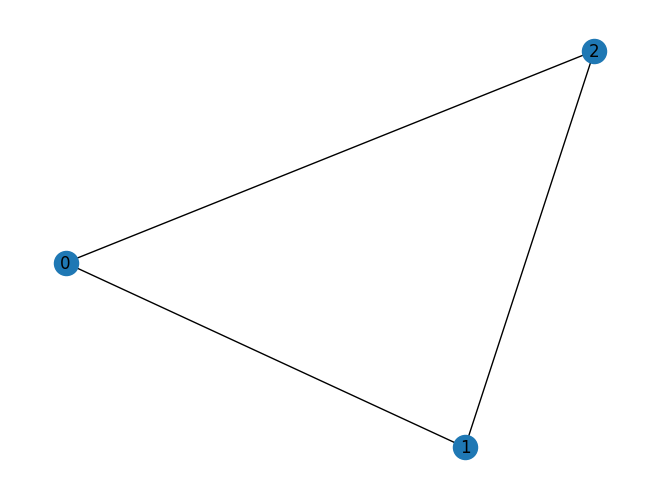

In [ ]:
tsp.draw()

In [ ]:

#INITIALIZING FUNCTION FOR COST OPERATOR
def get_cost_operator_circuit(distance_matrix, gamma):
    
    v = len(distance_matrix)
    n = v**2
    D = [item for sublist in distance_matrix for item in sublist]
    qc = QuantumCircuit(n,n)
    
    for iteration in range(1):
        for i in range(n):
            qc.rz(gamma[iteration] * D[i] / (2 * pi), i)  # Fix the gamma indexing here

        for i in range(v):
            for j in range(i):
                if i != j:
                     qc.rzz(20 * gamma[iteration] / pi, (j + i * v), i + j * v)
    qc.barrier()
    return qc
    

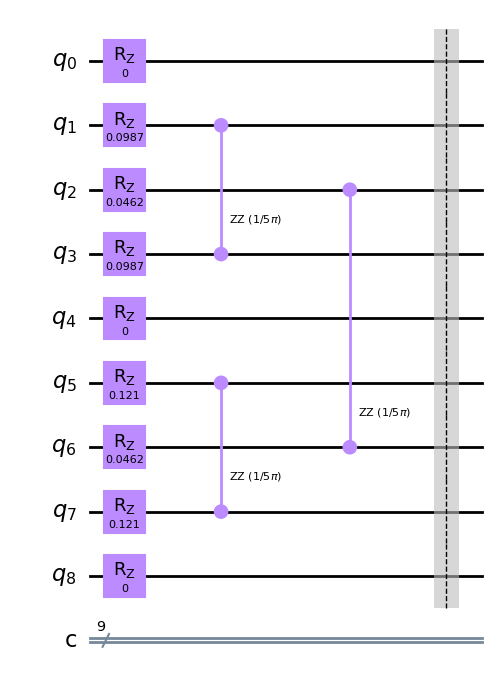

In [ ]:
#CHECKING COST OPERATOR WITH DUMMY GAMMA
gam = [0.01]
costOP = get_cost_operator_circuit(adj_matrix,gam)

costOP.draw()

In [ ]:
#INITIALIZING FUNCTIONS FOR MIXER OPERATOR
def get_mixer_operator_circuit(distance_matrix, beta):
    v = len(distance_matrix)
    n = v**2
    qc = QuantumCircuit(n,n)
    for iteration in range(1):
        for i in range(0, v):
            qc.rxx(-beta[iteration], i*v, (i*v+1))
            qc.rxx(-beta[iteration], (i*v+1), (i*v+2))

            qc.ryy(-beta[iteration], i * v, (i * v + 1))
            qc.ryy(-beta[iteration], (i * v + 1), (i * v + 2))
    qc.barrier()
    
    return qc


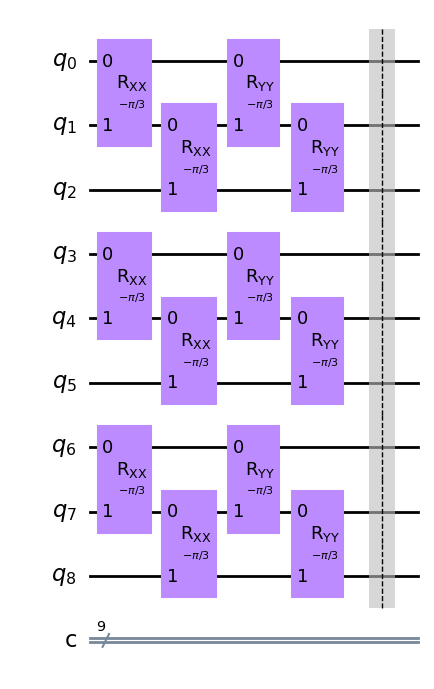

In [ ]:
#CHECKING MIXER OPERATOR WITH DUMMY BETA
qc = get_mixer_operator_circuit(adj_matrix, [np.pi/3])
qc.draw('mpl')

In [ ]:
#QAOA & QAOA+ CKTS
def get_qaoa_circuit(distance_matrix, parameters,p):
    v = len(distance_matrix)
    n = v**2
    beta = parameters[:p]
    gamma = parameters[p:2**p]
    qc = QuantumCircuit(n,n)
    t = p
    for qubit in range(n):
            
        qc.h(qubit)
    
    for i in range(p):

        qc_cost =qc.compose(get_cost_operator_circuit(adj_matrix, gamma))
        qc = qc_cost.compose(get_mixer_operator_circuit(adj_matrix, beta))
    
    
    
    # Finally, measure the result
    qc.measure(range(n), range(n))
    
    
    return qc

def get_qaoa_plus_circuit(distance_matrix, parameters,p):
    
    v = len(distance_matrix)
    n = v**2
    beta = parameters[:p]
    gamma = parameters[p:2*p]
    
    phi = ParameterVector('φ',n)
    PHI = parameters[2*p:]
    qc = QuantumCircuit(n,n)
    for qubit in range(n):
            
        qc.h(qubit)
    
    for i in range(p):

        qc_cost =qc.compose(get_cost_operator_circuit(adj_matrix, gamma))
        qc = qc_cost.compose(get_mixer_operator_circuit(adj_matrix, beta))
    
    
    

    # Finally, measure the result
    qc.barrier(range(n))
    
    bind_dict = {}     # THESE LINES ASSIGNS THE PARAMETERS OF BETA AND GAMMA TO THE QAOA CIRCUIT
    
    qc.parameters
    
    param =PHI #[beta:p,gamma:p,alpha:2**n]

    
    for i in range(n - 1):
    
        # THE BELOW LINES CONSTRUCTS THE PROBLEM INDEPENDENT LAYER WITH passed PARAMETERS 
        qc.crz(phi[i], i, i+1)
    qc.barrier()
    qc.x(range(n))


    for i, key in enumerate(qc.parameters):
        bind_dict[key] = param[i]

        
    qc = qc.bind_parameters(bind_dict)
    qc.measure(range(n), range(n))
    
    return qc

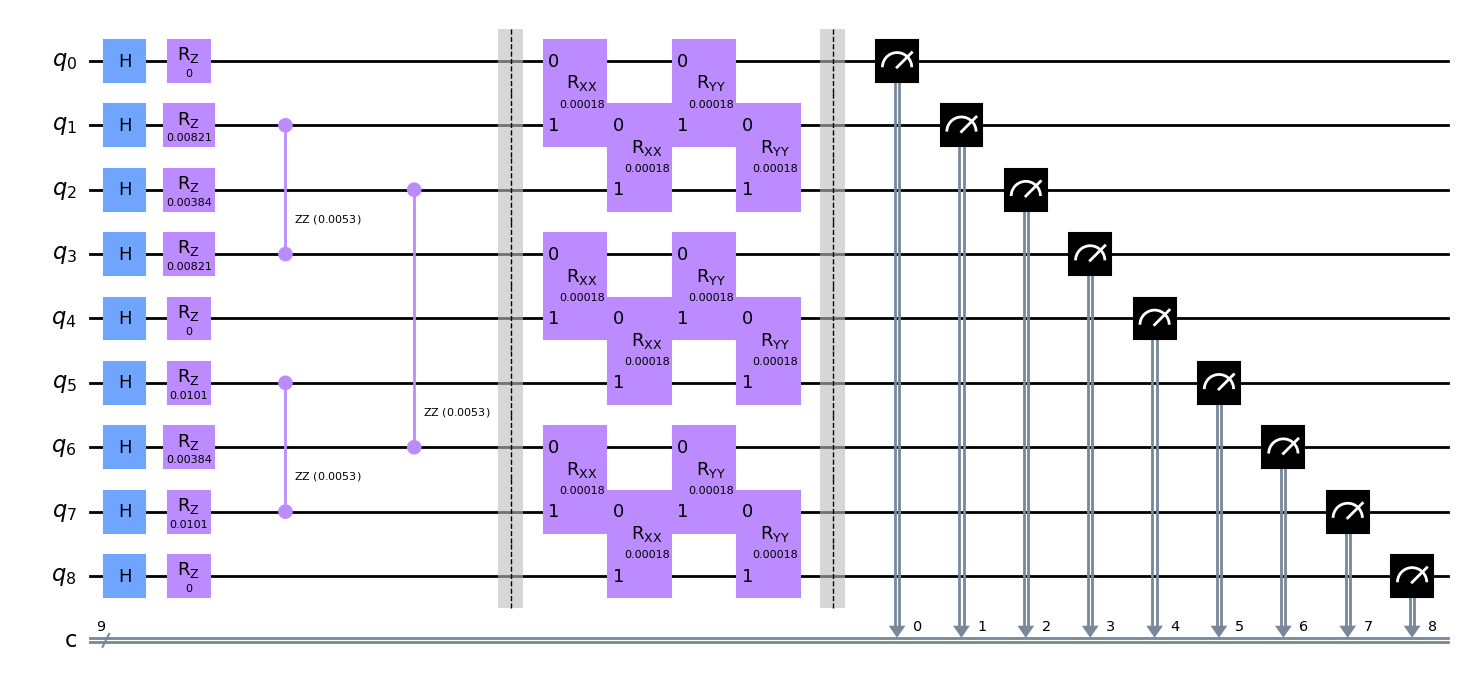

In [ ]:
#CHECKING STANDARD QAOA 
p=1
p_size = 2*p
parameters = np.random.uniform(-0.001*np.pi, 0.001*np.pi, size=p_size)

x = get_qaoa_circuit(adj_matrix, parameters,p)
x.draw()


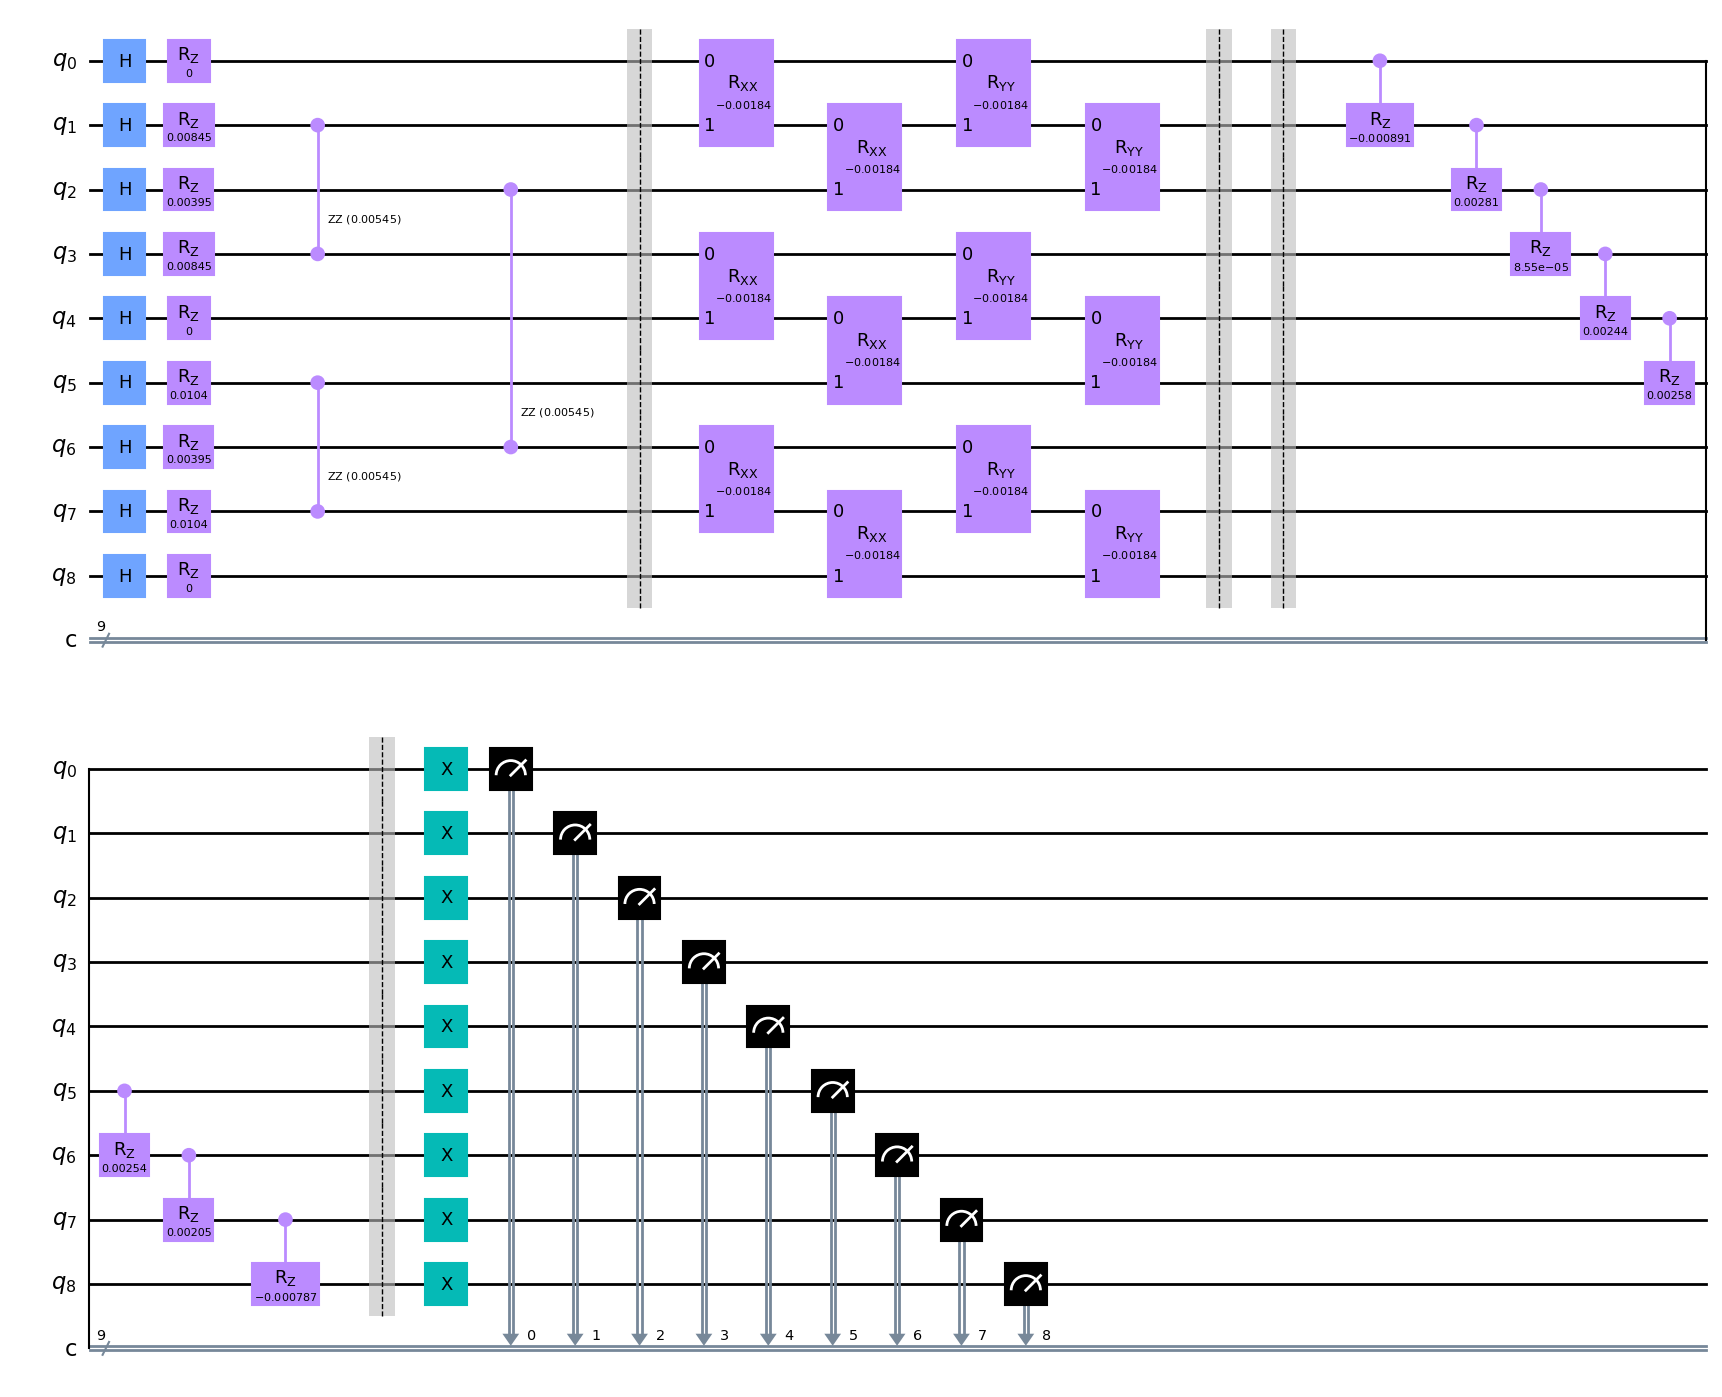

In [ ]:
#CHECKING QAOA+ 
p_size_plus =(2*p + n-1)
parameters = np.random.uniform(-0.001*np.pi, 0.001*np.pi, size=p_size_plus)
qc = get_qaoa_plus_circuit(adj_matrix, parameters,p)
qc.draw()

In [ ]:
def invert_counts(counts):
    return {k[::-1]:v for k, v in counts.items()}


In [ ]:
backend = Aer.get_backend('qasm_simulator')
job = execute(qc, backend)
result = job.result()
print(invert_counts(result.get_counts()))

{'000110010': 1, '000100111': 2, '001000111': 1, '001000000': 1, '100101111': 2, '011110000': 1, '000000110': 1, '010001111': 1, '101000001': 1, '101111011': 1, '110011000': 2, '110001011': 1, '000101010': 1, '000011110': 1, '111110011': 1, '110010110': 2, '011101000': 2, '001011111': 2, '010011111': 3, '010010100': 1, '101011011': 2, '001100000': 3, '100011010': 1, '000100100': 2, '110010101': 1, '100001010': 1, '001001110': 4, '111001100': 1, '110101100': 4, '111111101': 1, '010111110': 2, '101001100': 1, '001001000': 3, '000100010': 1, '100111101': 2, '001010010': 1, '010101010': 2, '100011001': 1, '101111010': 2, '011100110': 2, '000011001': 1, '010100100': 1, '111111000': 1, '011000101': 2, '001101001': 2, '111000001': 1, '010110110': 1, '011011111': 3, '110001001': 1, '111010000': 3, '110111010': 3, '110000101': 2, '011011100': 1, '010110101': 1, '001111100': 2, '010111011': 1, '000110101': 2, '111100111': 1, '001001111': 2, '101001000': 1, '110101010': 1, '101000000': 1, '011100

In [ ]:
def tsp_obj( result, adj_matrix: np.ndarray) -> float:
    x = result
    n = int(np.sqrt(len(x)))
    total_cost = 0.0

    for p__ in range(n):
        for i in range(n):
            if x[i * n + p__]:
                total_cost += adj_matrix[i, p__]

    return total_cost

tsp_obj('000111000', adj_matrix)

334.0

In [ ]:
def compute_tsp_energy(counts, distances):
    energy = 0
    total_counts = 0
    #counts =  correct_dict(counts, adj_matrix)
    
    for meas, meas_count in counts.items():
        binary_list = [int(bit) for bit in meas]
        meas_arr = np.array(binary_list)
        obj_for_meas = tsp_obj(meas_arr,adj_matrix)
        energy += obj_for_meas * meas_count
        total_counts += meas_count
    return (energy /total_counts)
compute_tsp_energy(invert_counts(result.get_counts()), adj_matrix)

164.1279296875

In [ ]:
def get_black_box_objective(distance_matrix,p):
    backend = Aer.get_backend('qasm_simulator')
    def f(theta):
        # let's assume first half is betas, second half is gammas
        parameters = theta
        qc =get_qaoa_circuit(adj_matrix, parameters,p)
        counts = execute(qc, backend, seed_simulator=10).result().get_counts()
        # return the energy
        return compute_tsp_energy(invert_counts(counts), distance_matrix)
    return f
def get_black_box_objective_plus(distance_matrix,p):
    backend = Aer.get_backend('qasm_simulator')
    def f(theta):
        # let's assume first half is betas, second half is gammas
        parameters = theta
        qc = get_qaoa_plus_circuit(adj_matrix, parameters,p)
        counts = execute(qc, backend, seed_simulator=10).result().get_counts()
        # return the energy
        return compute_tsp_energy(invert_counts(counts),distance_matrix )
    return f

In [ ]:
# p is the number of QAOA alternating operators
def run_qaoa(adj_matrix,method,param, p):
    
    obj = get_black_box_objective(adj_matrix, p)

    init_point =param
    for i in range(p):
        # We are going to limit the number of iterations to 2500
        res_sample = minimize(obj, init_point, method=method, options={'maxiter':5000, 'disp': True})
        init_point = res_sample['x']
    
    return res_sample
param = np.random.uniform(-0.001*np.pi, 0.001*np.pi, size=2*p)
k =run_qaoa(adj_matrix,'TNC',param, p)


/tmp/ipykernel_124/2679032353.py:9: DeprecationWarning: 'maxiter' has been deprecated in favor of 'maxfun' and will be removed in SciPy 1.11.0.
  res_sample = minimize(obj, init_point, method=method, options={'maxiter':5000, 'disp': True})
  NIT   NF   F                       GTG
    0    1  1.669042968750000E+02   0.00000000E+00
tnc: |pg| = 0 -> local minimum
    0    1  1.669042968750000E+02   0.00000000E+00
tnc: Local minima reach (|pg| ~= 0)


In [ ]:
# p is the number of QAOA alternating operators
def run_qaoa_plus(adj_matrix,methods,params, p):
    
    obj_plus = get_black_box_objective_plus(adj_matrix, p)
    init_point_plus = params

    for i in range(p):
        # We are going to limit the number of iterations to 2500
        res_sample_plus = minimize(obj_plus, init_point_plus, method=methods, options={'maxiter':5000, 'disp': True})
        init_point_plus = res_sample_plus['x']
    return res_sample_plus
p=1
params =np.random.uniform(-0.001*np.pi, 0.001*np.pi, size=(2*p+(n-1)))
run_qaoa_plus(adj_matrix,'TNC',params, p)



# We are going to limit the number of iterations to 2500


/tmp/ipykernel_124/3497938634.py:9: DeprecationWarning: 'maxiter' has been deprecated in favor of 'maxfun' and will be removed in SciPy 1.11.0.
  res_sample_plus = minimize(obj_plus, init_point_plus, method=methods, options={'maxiter':5000, 'disp': True})


     fun: 166.904296875
     jac: array([0., 0., 0., 0., 0., 0., 0., 0., 0., 0.])
 message: 'Local minimum reached (|pg| ~= 0)'
    nfev: 11
     nit: 0
  status: 0
 success: True
       x: array([ 0.00091375,  0.00236296, -0.00279654,  0.00256522,  0.00088638,
        0.00182132,  0.00043198,  0.00043117,  0.00311763,  0.00072852])

In [23]:

'''
print(App_ratio_qaoa,App_ratio_plus)
print('correct_cost_qaoa',correct_cost_qaoa)
print('obtained_cost_qaoa' , res_sample['fun'])
print('obtained_cost_plus' , res_sample_plus['fun'])'''

"\nprint(App_ratio_qaoa,App_ratio_plus)\nprint('correct_cost_qaoa',correct_cost_qaoa)\nprint('obtained_cost_qaoa' , res_sample['fun'])\nprint('obtained_cost_plus' , res_sample_plus['fun'])"

0.5749318801089919

In [26]:
#RUNNING QAOA/+ ITERATIVLY FOR BENCHMARK where method is optimizer t is trial and p is layer num 
#s_list is standard qaoa output list, plus_list is qaoa+'s and t list is trial count
def Benchmark_TSP(adj_matrix ,method,t,p):
    s_list = []
    plus_list = []
    t_list = []
    parameters = np.random.uniform(-0.001*np.pi, 0.001*np.pi, size=2*p+(n-1))
    s_param = parameters[:2*p]
    
    for i in range(t):
        
        res_sample = run_qaoa(adj_matrix,method,s_param, p)
        res_sample_plus = run_qaoa_plus(adj_matrix,method,parameters, p)
        obtained_cost_qaoa = res_sample['fun']
        obtained_cost_plus = res_sample_plus['fun']
        correct_cost_qaoa = tsp_brute_force(adj_matrix)
        if(obtained_cost_qaoa/correct_cost_qaoa>1):
            App_ratio_qaoa= correct_cost_qaoa/obtained_cost_qaoa
            App_ratio_plus= correct_cost_qaoa/obtained_cost_plus
        else:
            
            App_ratio_qaoa= obtained_cost_qaoa/correct_cost_qaoa
            App_ratio_plus= obtained_cost_plus/correct_cost_qaoa
        
        s_list.append(App_ratio_qaoa)
        plus_list.append(App_ratio_plus)
        t_list.append(i)
    return s_list ,plus_list ,t_list

 
s_list ,plus_list ,t_list = Benchmark_TSP(adj_matrix,'TNC',1,p)
        
        

/tmp/ipykernel_124/2679032353.py:9: DeprecationWarning: 'maxiter' has been deprecated in favor of 'maxfun' and will be removed in SciPy 1.11.0.
  res_sample = minimize(obj, init_point, method=method, options={'maxiter':5000, 'disp': True})
  NIT   NF   F                       GTG
    0    1  1.669042968750000E+02   0.00000000E+00
tnc: |pg| = 0 -> local minimum
    0    1  1.669042968750000E+02   0.00000000E+00
tnc: Local minima reach (|pg| ~= 0)
  NIT   NF   F                       GTG
    0    1  1.668437500000000E+02   0.00000000E+00
tnc: |pg| = 0 -> local minimum
    0    1  1.668437500000000E+02   0.00000000E+00
tnc: Local minima reach (|pg| ~= 0)


In [27]:
print(s_list ,plus_list ,t_list)

[0.9994269273952096] [0.999064371257485] [0]


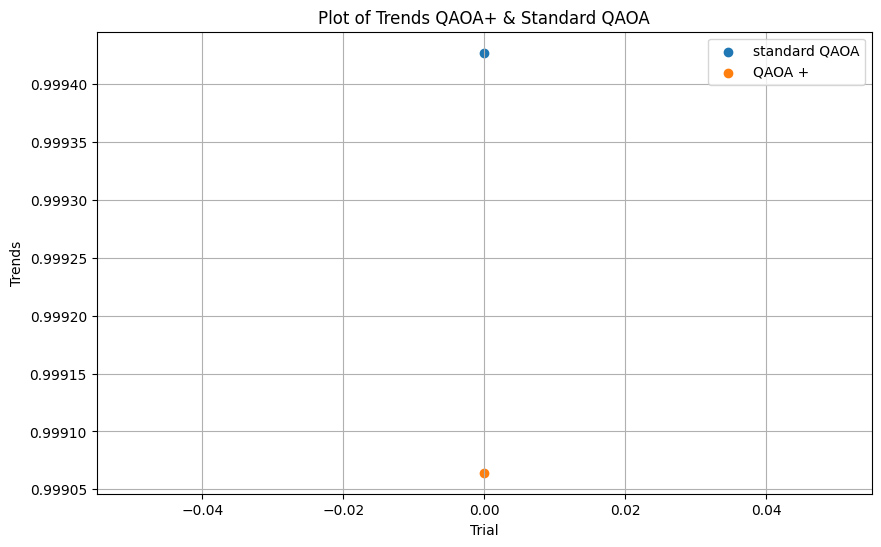

In [28]:
plt.figure(figsize=(10, 6))
plt.scatter(t_list, s_list, label='standard QAOA')
plt.scatter(t_list, plus_list, label='QAOA +')

# Add labels and title
plt.xlabel('Trial')
plt.ylabel('Trends')
plt.title('Plot of Trends QAOA+ & Standard QAOA')

# Add a legend
plt.legend()

# Show the plot
plt.grid(True)
plt.show()

/tmp/ipykernel_124/27966307.py:10: DeprecationWarning: 'maxiter' has been deprecated in favor of 'maxfun' and will be removed in SciPy 1.11.0.
  res_sample = minimize(obj, init_point, method=method, options={'maxiter':5000, 'disp': True})
  NIT   NF   F                       GTG
    0    1  1.668193359375000E+02   0.00000000E+00
tnc: |pg| = 0 -> local minimum
    0    1  1.668193359375000E+02   0.00000000E+00
tnc: Local minima reach (|pg| ~= 0)
  NIT   NF   F                       GTG
    0    1  1.668193359375000E+02   0.00000000E+00
tnc: |pg| = 0 -> local minimum
    0    1  1.668193359375000E+02   0.00000000E+00
tnc: Local minima reach (|pg| ~= 0)
  NIT   NF   F                       GTG
    0    1  1.668193359375000E+02   0.00000000E+00
tnc: |pg| = 0 -> local minimum
    0    1  1.668193359375000E+02   0.00000000E+00
tnc: Local minima reach (|pg| ~= 0)
  NIT   NF   F                       GTG
    0    1  1.668193359375000E+02   0.00000000E+00
tnc: |pg| = 0 -> local minimum
    0   

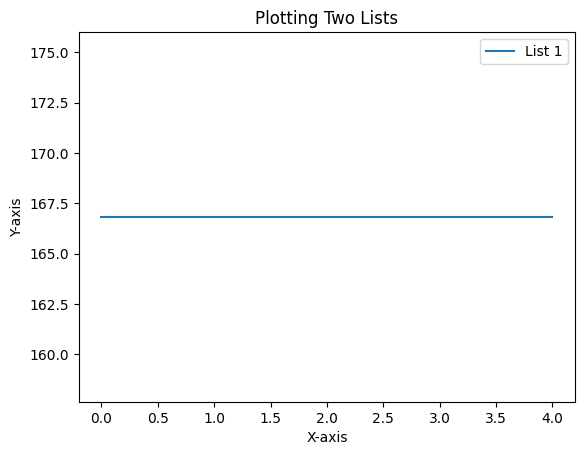

[array([ 0.00163557,  0.0018556 ,  0.00037088,  0.0009774 , -0.00137898,
        0.00210211,  0.00174317,  0.00075522,  0.00132111, -0.00010535]), array([ 0.00163557,  0.0018556 ,  0.00037088,  0.0009774 , -0.00137898,
        0.00210211,  0.00174317,  0.00075522,  0.00132111, -0.00010535]), array([ 0.00163557,  0.0018556 ,  0.00037088,  0.0009774 , -0.00137898,
        0.00210211,  0.00174317,  0.00075522,  0.00132111, -0.00010535]), array([ 0.00163557,  0.0018556 ,  0.00037088,  0.0009774 , -0.00137898,
        0.00210211,  0.00174317,  0.00075522,  0.00132111, -0.00010535]), array([ 0.00163557,  0.0018556 ,  0.00037088,  0.0009774 , -0.00137898,
        0.00210211,  0.00174317,  0.00075522,  0.00132111, -0.00010535])]


In [29]:

def run_qaoa_dummy(adj_matrix,method,param, p):
    
    obj = get_black_box_objective(adj_matrix, p)
    p_list = []
    res_list = []
    init = []
    init_point =param
    for i in range(p):
        # We are going to limit the number of iterations to 2500
        res_sample = minimize(obj, init_point, method=method, options={'maxiter':5000, 'disp': True})
        init_point = res_sample['x']
        p_list.append(i)
        res_list.append(res_sample['fun'])
        init.append(init_point)
    
    return res_list, p_list, init 
p = 5
param = np.random.uniform(-0.001*np.pi, 0.001*np.pi, size=2*p)
res_sample , p_list,init =run_qaoa_dummy(adj_matrix,'TNC',param, p)
# Create a new figure
plt.figure()

# Plot the data from the first list
plt.plot(p_list, res_sample, label='List 1')

# Plot the data from the second list


# Add labels and title
plt.xlabel('X-axis')
plt.ylabel('Y-axis')
plt.title('Plotting Two Lists')
plt.legend()

# Show the plot
plt.show()
print(init)






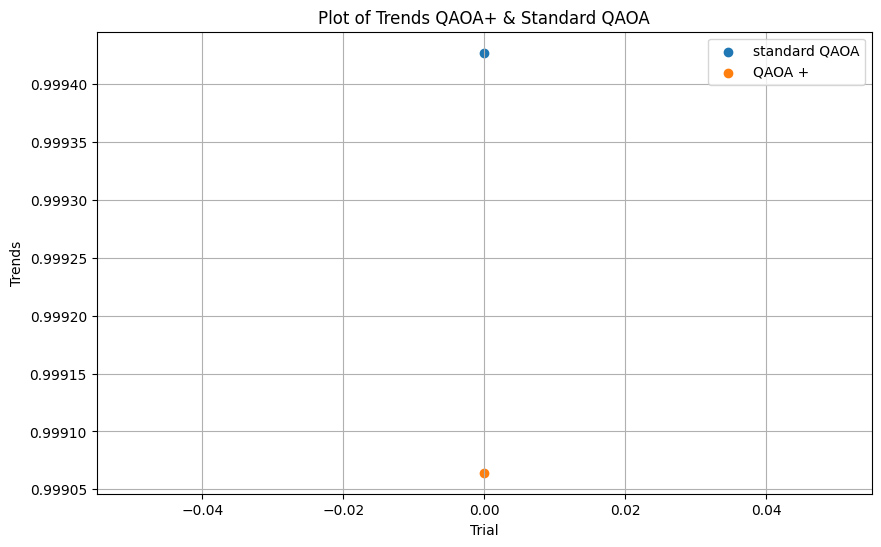

In [30]:
plt.figure(figsize=(10, 6))
plt.scatter(t_list, s_list, label='standard QAOA')
plt.scatter(t_list, plus_list, label='QAOA +')

# Add labels and title
plt.xlabel('Trial')
plt.ylabel('Trends')
plt.title('Plot of Trends QAOA+ & Standard QAOA')

# Add a legend
plt.legend()

# Show the plot
plt.grid(True)
plt.show()